I initally tried using resnet50 for this classification task. I began overfitting at 74% validation accruacy for resnet50.  Since resnet50 took a very long time to train, I switched over to resnet34 for tuning my model.  Eventually I got 81% accruacy with resnet34.  I added a dropout layer in between the linear layer to help combat overfitting. 

To run this code please sequentially execute the code cells. 

#Setup 

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
import json
import pandas as pd
from datetime import datetime
import pdb 
from google.colab import drive
import pandas as pd
from psutil import virtual_memory
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil
!pip install wandb --upgrade
import wandb

In [ ]:
class SetUpColab():

  def __init__(self):
    pass
  
  #Determines how much ram the runtime has
  @staticmethod
  def runtime_info():
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
      print('Not using a high-RAM runtime')
    else:
      print('You are using a high-RAM runtime!')
    !nvidia-smi
    
  @staticmethod
  def mount_google_drive():
    drive.mount('/content/gdrive')
  
  #Sets up environement for use with kaggle api
  @staticmethod
  def set_up_kaggle():
    !pip uninstall -y kaggle
    !pip install --upgrade pip
    !pip install kaggle==1.5.6
    !mkdir .kaggle

    token = {"username":"nicholasmagal","key":"9bf671834d75b58fac2b037da15f4cf0"}
    with open('/content/.kaggle/kaggle.json', 'w') as file:
      json.dump(token, file)
    
    for i in range(2):
      !chmod 600 /content/.kaggle/kaggle.json
      !cp /content/.kaggle/kaggle.json /root/.kaggle/
      !kaggle config set -n path -v /content
  
  @staticmethod
  def change_dir(path):
    os.chdir(path)
  
  @staticmethod
  def setup_wandb():
    wandb.login()

  
  #Calls above methods to do a complete Collab setup, ready to run ml models :D Note may want to change this per competition
  @staticmethod
  def complete_set_up():
    SetUpColab.runtime_info()
    #SetUpColab.mount_google_drive()
    SetUpColab.set_up_kaggle()
    SetUpColab.setup_wandb()
  

In [ ]:
data_url = 'idl-fall21-hw2p2s1-face-classification'
data_path = '/content/competitions/' + data_url

In [ ]:
SetUpColab.complete_set_up()
!kaggle competitions download -c idl-fall21-hw2p2s1-face-classification
SetUpColab.change_dir(data_path)
!unzip idl-fall21-hw2p2s1-face-classification.zip

#Data

In [ ]:
#Different transforms
transforms_testing = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transforms_training = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                      torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                      torchvision.transforms.RandomHorizontalFlip(),
                                                      torchvision.transforms.RandomRotation(degrees=50),
                                                      torchvision.transforms.CenterCrop((64,64))])


train_dataset = torchvision.datasets.ImageFolder(root=data_path+'/train_data', 
                                                       transform=transforms_training)


val_dataset = torchvision.datasets.ImageFolder(root=data_path+'/val_data', 
                                                       transform=transforms_testing)



Data Inspection 

In [ ]:
image = train_dataset[0][0]
#Our data is organized by CXHXW
print("Image Dimensions",image.shape)

total_classes = len(train_dataset.classes)
print("Total classes:", total_classes)

total_training_examples = len(train_dataset)
print("Total amount of training data",total_training_examples)


Image Dimensions torch.Size([3, 64, 64])
Total classes: 4000
Total amount of training data 380638


In [ ]:
training_targets = pd.Series(train_dataset.targets)
class_compositions = (training_targets.value_counts()).divide(len(train_dataset))

#There seems to be some class imbalance on the dataset
class_compositions

3638    0.000654
868     0.000591
1273    0.000581
2307    0.000578
1189    0.000562
          ...   
379     0.000055
1354    0.000055
2927    0.000053
977     0.000050
3810    0.000039
Length: 4000, dtype: float64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


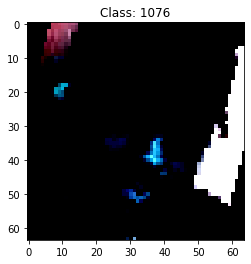

In [ ]:
#Visualize Random Data Points
index = random.randint(0,total_training_examples)
image = train_dataset[index][0].permute(1,2,0)
class_id = str(train_dataset[index][1])
plt.title("Class: "+class_id)
plt.imshow(train_dataset[index][0].permute(1,2,0))

# Building Model

In [ ]:
class ResidualBlockResnet50(nn.Module):
  def __init__(self, input_channel_size, keep_dim = True, stride=1, first_block=False):
    super().__init__()

    #Depending if we are changing our dimensions, we will have to initlize our parameters differently
    if keep_dim == True:
      
      #Due to non symmetry of resnet have to do this 
      if first_block==True:
        output_size = input_channel_size
      else:
        output_size = int(input_channel_size/4)
    
    else:
      output_size = int(input_channel_size/2)

    self.shortcut_x = nn.Sequential(
        nn.Conv2d(in_channels=input_channel_size, out_channels= output_size*4, kernel_size= 1, stride = stride),
        nn.BatchNorm2d(output_size*4))

    self.conv0 = nn.Conv2d(in_channels=input_channel_size, out_channels = output_size, kernel_size=1,stride=stride, bias = False)
    self.bn_0 = nn.BatchNorm2d(output_size)
    self.reLU_0 = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=output_size, out_channels = output_size, kernel_size = 3, stride = 1, padding='same', bias = False)
    self.bn_1 = nn.BatchNorm2d(output_size)
    self.reLU_1 = nn.ReLU()

    self.conv2 = nn.Conv2d(in_channels=output_size, out_channels = output_size*4, kernel_size = 1, stride = 1, bias = False)
    self.bn_2 = nn.BatchNorm2d(output_size*4)
    self.reLU_2 = nn.ReLU()

  def forward(self,x):

    shortcut = self.shortcut_x(x)
    out = self.conv0(x)
    out = self.bn_0(out)
    out = self.reLU_0(out)
    
    out = self.conv1(out)
    out = self.bn_1(out)
    out = self.reLU_1(out)

    out = self.conv2(out)
    out = self.bn_2(out)
    out = self.reLU_2(out)

    out = out + shortcut

    return(out)


In [ ]:
class Resnet50(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3, stride =1, padding='same',bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(), 
        ResidualBlockResnet50(input_channel_size = 64, first_block = True ),
        ResidualBlockResnet50(input_channel_size = 256),
        ResidualBlockResnet50(input_channel_size = 256),
        ResidualBlockResnet50(input_channel_size = 256, first_block = True, keep_dim = False, stride = 2 ),
        ResidualBlockResnet50(input_channel_size = 512),
        ResidualBlockResnet50(input_channel_size = 512),
        ResidualBlockResnet50(input_channel_size = 512),
        ResidualBlockResnet50(input_channel_size = 512 , first_block = True, keep_dim = False, stride = 2),
        ResidualBlockResnet50(input_channel_size = 1024),
        ResidualBlockResnet50(input_channel_size = 1024),
        ResidualBlockResnet50(input_channel_size = 1024),
        ResidualBlockResnet50(input_channel_size = 1024),
        ResidualBlockResnet50(input_channel_size = 1024),
        ResidualBlockResnet50(input_channel_size = 1024 , first_block = True, keep_dim = False, stride = 2),
        ResidualBlockResnet50(input_channel_size = 2048),
        ResidualBlockResnet50(input_channel_size = 2048),
        nn.AdaptiveAvgPool2d((1,1)),#add a dropout here to combat overfitting
        nn.Flatten(),
        nn.Dropout(p=0.2)       
    )
    
    self.linear_layer = nn.Linear(2048,4000)
  
  def forward(self,x):
    x = self.cnn_layers(x)
    x = self.linear_layer(x)
    return(x)


In [ ]:
class ResidualBlockResnet34(nn.Module):
  def __init__(self, input_channel_size, keep_dim = True, stride=1):
    super().__init__()

    #Depending if we are changing our dimensions, we will have to initlize our parameters differently
    if keep_dim == True:  
      output_size = input_channel_size
    
    else:
      output_size = int(input_channel_size*2)

    if stride > 1:
      self.shortcut_x = nn.Sequential(
      nn.Conv2d(in_channels=input_channel_size, out_channels= output_size, kernel_size = 3, stride = stride, bias = False),
      nn.BatchNorm2d(output_size))
      self.conv0 = nn.Conv2d(in_channels=input_channel_size, out_channels = output_size, kernel_size=3,stride=stride, bias = False)
    
    else:
      self.shortcut_x = nn.Identity()
      self.conv0 = nn.Conv2d(in_channels=input_channel_size, out_channels = output_size, kernel_size=3,stride=stride, padding = 'same', bias = False)

    self.bn_0 = nn.BatchNorm2d(output_size)
    self.reLU_0 = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=output_size, out_channels = output_size, kernel_size = 3, stride = 1, padding='same', bias = False)
    self.bn_1 = nn.BatchNorm2d(output_size)
    self.reLU_1 = nn.ReLU()

  def forward(self,x):
    
    shortcut = self.shortcut_x(x)
    
    out = self.conv0(x)
    out = self.bn_0(out)
    out = self.reLU_0(out)
    
    out = self.conv1(out)
    out = self.bn_1(out)
    out = self.reLU_1(out)

    out = out + shortcut

    return(out)

In [ ]:
class Resnet34(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3, stride =1, padding='same',bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(), 
        ResidualBlockResnet34(input_channel_size = 64),
        ResidualBlockResnet34(input_channel_size = 64),
        ResidualBlockResnet34(input_channel_size = 64),
        ResidualBlockResnet34(input_channel_size = 64, keep_dim = False, stride = 2),
        ResidualBlockResnet34(input_channel_size = 128),
        ResidualBlockResnet34(input_channel_size = 128),
        ResidualBlockResnet34(input_channel_size = 128),
        ResidualBlockResnet34(input_channel_size = 128, keep_dim = False, stride = 2),
        ResidualBlockResnet34(input_channel_size = 256),
        ResidualBlockResnet34(input_channel_size = 256),
        ResidualBlockResnet34(input_channel_size = 256),
        ResidualBlockResnet34(input_channel_size = 256),
        ResidualBlockResnet34(input_channel_size = 256),
        ResidualBlockResnet34(input_channel_size = 256, keep_dim = False, stride = 2),
        ResidualBlockResnet34(input_channel_size = 512),
        ResidualBlockResnet34(input_channel_size = 512),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.2) 

    )

    self.linear_layer = nn.Linear(512,4000)

  
  def forward(self, x):
    x = self.cnn_layers(x)
    x = self.linear_layer(x)
    return(x)


In [ ]:
class ModelComponents():
  def __init__(self):
    pass
  
  @staticmethod
  def load_model_for_inference(save_path, model):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

  @staticmethod
  def load_model_for_more_training(save_path, model, optimizer, schedular):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    schedular.load_state_dict(checkpoint['scheduler_state_dict'])

    return model, optimizer, schedular

  @staticmethod
  def create_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device is on",device)
    return(device)
  
  @staticmethod
  def create_data_loader(dataset, shuffle, batch_size = 128, num_workers = 1, pin_memory = True):
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                   batch_size = batch_size,
                                                   shuffle = shuffle,
                                                   num_workers = num_workers,
                                                   pin_memory = pin_memory)
    return(data_loader)
    
  def save_model(self, model, optimizer, path, scheduler):
    torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict' : scheduler.state_dict(),
    }, path)

  def train(self, model, train_loader, dev_dataloader, optimizer, epochs, loss_function, path, device, length_val, scheduler):
    for epoch in (range(epochs)):
      avg_loss = 0.0

      #training on data
      model.train()
      for batch_num, (feats, labels) in enumerate(train_loader):
        feats, labels = feats.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(feats)
        loss = loss_function(output, labels.long())
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()

        if batch_num % 10 == 9:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch, batch_num+1, avg_loss/50))
            wandb.log({"average loss" : avg_loss/50, "epoch" : epoch})
            avg_loss = 0.0 

        #Clean Up
        torch.cuda.empty_cache()
        del feats
        del labels
        del loss
      
      #Running our model against validation examples
      with torch.no_grad():
        model.eval()
        num_correct = 0
        for batch_num, (x, y) in enumerate(dev_dataloader):
          x, y = x.to(device), y.to(device)
          outputs = model(x)
          num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()
        
        val_acc = num_correct / length_val
        print('Epoch: {}, Validation Accuracy: {:.2f}'.format(epoch, val_acc))
        wandb.log({"Validation Accuracy" : val_acc})
      
        scheduler.step(val_acc)

        to_save_path = path + str(epoch) + '.pt'
        self.save_model(model, optimizer, to_save_path, scheduler)

  @staticmethod
  def inference(model, test_loader,device):
    with torch.no_grad():
      model.eval()
      predicted_classes_total = []
      
      for x,y in test_loader:
        x = x.to(device)
        test_out = model(x)
        #pdb.set_trace()
        prediction_classes = torch.argmax(test_out, dim = 1)

        prediction_classes = prediction_classes.tolist()
        predicted_classes_total.extend(prediction_classes)
        
      
      return(predicted_classes_total)

#Deploying Model

In [ ]:
component_builder = ModelComponents()

In [ ]:
#Use this to start a new training session from scratch
config = {
    'epochs': 30,
    'learning_rate' :.1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'loss' : 'crossentropysoftmax',
    'schedular' : 'ReduceLROnPlateau',
    'weight_decay' : 5*10**-5,
    'transformations' :'normalize, horizontalflip, rotation, centercrop '
    }

wandb.init(project="resnet50_classification", config=config)



device = component_builder.create_device()

training_data_loader = component_builder.create_data_loader(train_dataset, True, batch_size=config["batch_size"])
val_data_loader = component_builder.create_data_loader(val_dataset, False,batch_size=config["batch_size"] )
len_val = len(val_dataset)

cnn_model = Resnet50(3)
cnn_model = cnn_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=config['learning_rate'], weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=.2)

save_path = "/content/drive/MyDrive/IDL/HW/HW2/P1/saves_run_2/"

wandb: Currently logged in as: nicholasmagal (use `wandb login --relogin` to force relogin)


Device is on cuda:0


In [ ]:
#Use this to resume training
config = {
    'epochs': 30,
    'learning_rate' :.1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'loss' : 'crossentropysoftmax',
    'schedular' : 'ReduceLROnPlateau',
    'weight_decay' : 5*10**-5,
    'transformations' :'normalize, horizontalflip, rotation, centercrop '
    }

device = component_builder.create_device()

training_data_loader = component_builder.create_data_loader(train_dataset, True, batch_size=config["batch_size"])
val_data_loader = component_builder.create_data_loader(val_dataset, False,batch_size=config["batch_size"] )
len_val = len(val_dataset)

cnn_model = Resnet50(3)
cnn_model = cnn_model.to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=config['learning_rate'], weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=.2)
loss_function = nn.CrossEntropyLoss()

model_path = '/content/drive/MyDrive/IDL/HW/HW2/P1/saves_run_2/12.pt'
cnn_model, optimizer,scheduler  = component_builder.load_model_for_more_training(model_path,cnn_model,optimizer,scheduler)
save_path = "/content/drive/MyDrive/IDL/HW/HW2/P1/saves_run_2/"

Device is on cuda:0


In [ ]:
wandb.init(project="resnet50_classification", config=config)
component_builder.train(cnn_model, training_data_loader, val_data_loader, optimizer, config["epochs"],loss_function, save_path, device, len_val,scheduler)
wandb.finish()

Epoch: 0	Batch: 10	Avg-Loss: 0.1984
Epoch: 0	Batch: 20	Avg-Loss: 0.1651
Epoch: 0	Batch: 30	Avg-Loss: 0.2026
Epoch: 0	Batch: 40	Avg-Loss: 0.1937
Epoch: 0	Batch: 50	Avg-Loss: 0.1681
Epoch: 0	Batch: 60	Avg-Loss: 0.1792
Epoch: 0	Batch: 70	Avg-Loss: 0.1920
Epoch: 0	Batch: 80	Avg-Loss: 0.1853
Epoch: 0	Batch: 90	Avg-Loss: 0.1680
Epoch: 0	Batch: 100	Avg-Loss: 0.1574
Epoch: 0	Batch: 110	Avg-Loss: 0.2018
Epoch: 0	Batch: 120	Avg-Loss: 0.1829
Epoch: 0	Batch: 130	Avg-Loss: 0.1804
Epoch: 0	Batch: 140	Avg-Loss: 0.1984
Epoch: 0	Batch: 150	Avg-Loss: 0.1876
Epoch: 0	Batch: 160	Avg-Loss: 0.1889
Epoch: 0	Batch: 170	Avg-Loss: 0.1496
Epoch: 0	Batch: 180	Avg-Loss: 0.1855
Epoch: 0	Batch: 190	Avg-Loss: 0.1795
Epoch: 0	Batch: 200	Avg-Loss: 0.1873
Epoch: 0	Batch: 210	Avg-Loss: 0.1616
Epoch: 0	Batch: 220	Avg-Loss: 0.1647
Epoch: 0	Batch: 230	Avg-Loss: 0.1700
Epoch: 0	Batch: 240	Avg-Loss: 0.1873
Epoch: 0	Batch: 250	Avg-Loss: 0.1731
Epoch: 0	Batch: 260	Avg-Loss: 0.1560
Epoch: 0	Batch: 270	Avg-Loss: 0.2075
Epoch: 0	B

#Inference

In [ ]:
component_builder = ModelComponents()

device = component_builder.create_device()

inference_model = Resnet34(3)
inference_model.to(device)

model_path = '/content/drive/MyDrive/IDL/HW/HW2/P1/saves_run_1/23.pt'
inference_model = component_builder.load_model_for_inference(model_path, inference_model)

Device is on cuda:0


In [ ]:
#Trick to get ImageFolder to load our data

data_dir = "/content/competitions/idl-fall21-hw2p2s1-face-classification/test_data"
data = os.listdir(data_dir)

class_dir = '/content/competitions/idl-fall21-hw2p2s1-face-classification/test_data/0'
os.mkdir(class_dir)

for file_name in data:
  shutil.move(os.path.join(data_dir, file_name), class_dir)

In [ ]:
transforms_testing = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_dataset = torchvision.datasets.ImageFolder(root=data_path+'/test_data/', 
                                                       transform=transforms_testing)

test_data_loader = component_builder.create_data_loader(test_dataset, shuffle=False)

In [ ]:
predictions = component_builder.inference(inference_model, test_data_loader, device)


In [ ]:
labels_transform = {val:key for key,val in train_dataset.class_to_idx.items()}

for i in range(8000):
  predictions[i] = labels_transform[predictions[i]]


#Turning Series into df for easy csv export
df = pd.DataFrame(predictions)
df.columns = ['label']

#Modifying index to conform to competition format
indexes = np.array(sorted(list(map(str, range(8000)))), dtype=np.int32)
indexes = indexes.tolist()
indexes_string = list(map(str,indexes))
indexes_appended = [s + ".jpg" for s in indexes_string]
df.insert(0,'id',indexes_appended) 

df['label'] = df['label'].astype(int)
df=df.set_index('id')

df.to_csv('/content/drive/MyDrive/IDL/HW/HW2/results9.csv')